In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import PIL
import PIL.Image
import keras

from tensorflow.keras.preprocessing import image_dataset_from_directory

print(tf.__version__)

2.3.1


Using TensorFlow backend.


In [2]:
print(keras.__version__)

2.3.0


In [3]:
data_dir = "/Users/maanitsharma/Desktop/Grape_research/fogarty_classification/forgarty_data_date/f_green_grape_models/fgM3FullSeason/"
CATEGORIES = ['gPhase1', 'gPhase3', 'gPhase5']

In [4]:
batch_size = 32
img_height = 224
img_width = 224

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  label_mode ='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 671 files belonging to 3 classes.
Using 537 files for training.


In [5]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  label_mode ='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 671 files belonging to 3 classes.
Using 134 files for validation.


In [6]:
class_names = train_dataset.class_names
print(class_names)

['gPhase1', 'gPhase3', 'gPhase5']


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

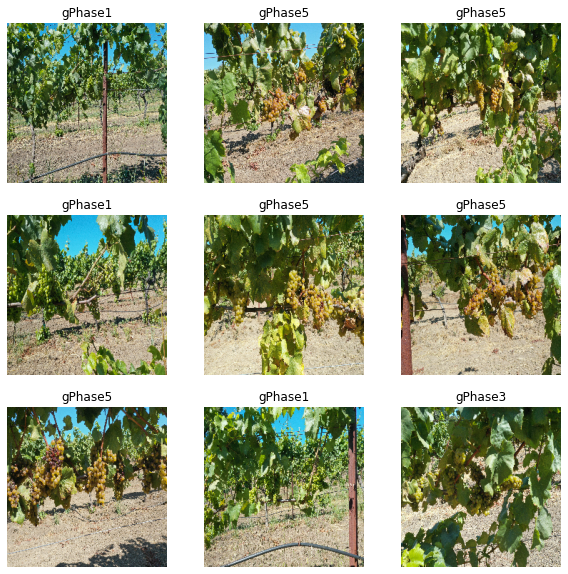

In [7]:
#for image_batch, labels_batch in train_dataset:
#  print(image_batch.shape)
#  print(labels_batch.shape)
#  break
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.where(labels[i]==1)[0][0]])
    plt.axis("off")

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
#Validation dataset has 2 batches that contain 32 images
test_dataset = validation_dataset.take(val_batches // 5) #We take 20% of the validation batches, the fist half, and use this as our test dataset

validation_dataset = validation_dataset.skip(val_batches // 5) #We take the other half, second batch, and this is our validation dataset.
 
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 1


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

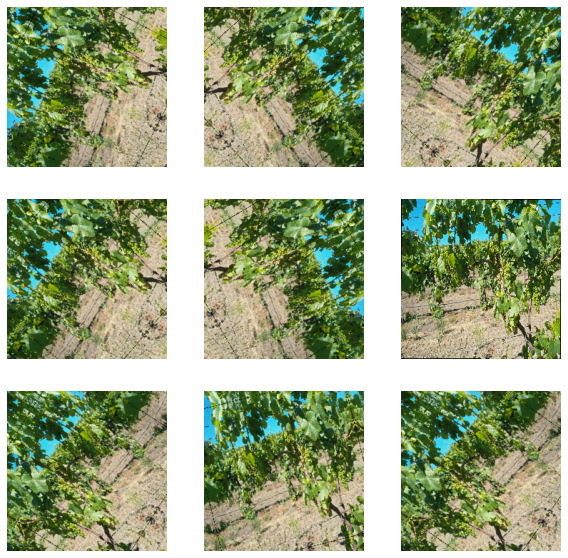

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
#Rescale pixel values of images from [0,255] to [-1,1] as resnet takes images with pixel values in the range [-1,1]
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [13]:
#Create base ResNet50 model with pretrained weights on imagenet dataset.
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                include_top=False,
                                               weights='imagenet')

In [14]:
# Convert each 224x224x3 image into a 7x7x2048 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [15]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [17]:
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
#For binary classification #prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [18]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)             

In [177]:
len(model.trainable_variables)

2

In [178]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 [==============================] - 7s 849ms/step - loss: 2.2284 - accuracy: 0.1797


In [179]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.23
initial accuracy: 0.18


In [180]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
41/41 [==============================] - 294s 7s/step - loss: 1.8461 - accuracy: 0.2397 - val_loss: 1.6074 - val_accuracy: 0.2734
Epoch 2/10
41/41 [==============================] - 301s 7s/step - loss: 1.6442 - accuracy: 0.2826 - val_loss: 1.4786 - val_accuracy: 0.3594
Epoch 3/10
41/41 [==============================] - 301s 7s/step - loss: 1.5749 - accuracy: 0.3310 - val_loss: 1.3612 - val_accuracy: 0.4453
Epoch 4/10
41/41 [==============================] - 293s 7s/step - loss: 1.4099 - accuracy: 0.4184 - val_loss: 1.2898 - val_accuracy: 0.4727
Epoch 5/10
41/41 [==============================] - 286s 7s/step - loss: 1.3848 - accuracy: 0.4091 - val_loss: 1.2604 - val_accuracy: 0.4961
Epoch 6/10
41/41 [==============================] - 297s 7s/step - loss: 1.3105 - accuracy: 0.4528 - val_loss: 1.1866 - val_accuracy: 0.5078
Epoch 7/10
41/41 [==============================] - 294s 7s/step - loss: 1.2615 - accuracy: 0.4785 - val_loss: 1.1248 - val_accuracy: 0.5547
Epoch 8/10
41

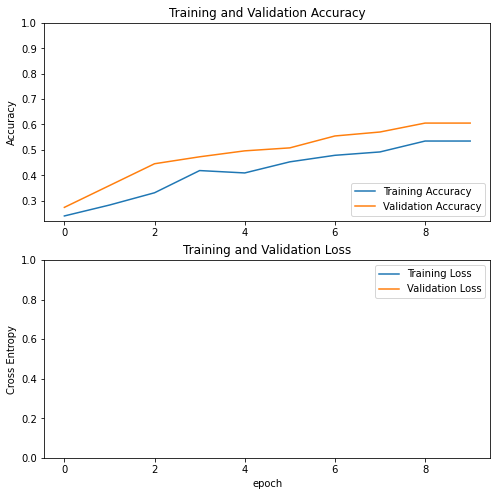

In [186]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [187]:
base_model.trainable = True

In [188]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [189]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice_4  [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_4 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)             

In [190]:
len(model.trainable_variables)

92

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
41/41 [==============================] - 329s 8s/step - loss: 0.8835 - accuracy: 0.6425 - val_loss: 0.8138 - val_accuracy: 0.6445
Epoch 11/20
41/41 [==============================] - 335s 8s/step - loss: 0.6933 - accuracy: 0.7198 - val_loss: 0.9345 - val_accuracy: 0.6133
Epoch 12/20
41/41 [==============================] - 329s 8s/step - loss: 0.5544 - accuracy: 0.7830 - val_loss: 0.6693 - val_accuracy: 0.7695
Epoch 13/20
41/41 [==============================] - 339s 8s/step - loss: 0.4697 - accuracy: 0.8189 - val_loss: 0.7648 - val_accuracy: 0.7148
Epoch 14/20
41/41 [==============================] - 2023s 49s/step - loss: 0.4048 - accuracy: 0.8368 - val_loss: 2.7794 - val_accuracy: 0.3945
Epoch 15/20
41/41 [==============================] - 314s 8s/step - loss: 0.3541 - accuracy: 0.8579 - val_loss: 1.2139 - val_accuracy: 0.6602
Epoch 16/20
41/41 [==============================] - 319s 8s/step - loss: 0.3320 - accuracy: 0.8657 - val_loss: 0.6249 - val_accuracy: 0.7930
Epoc

In [181]:
model.save("GreenModelV2June8.h5")

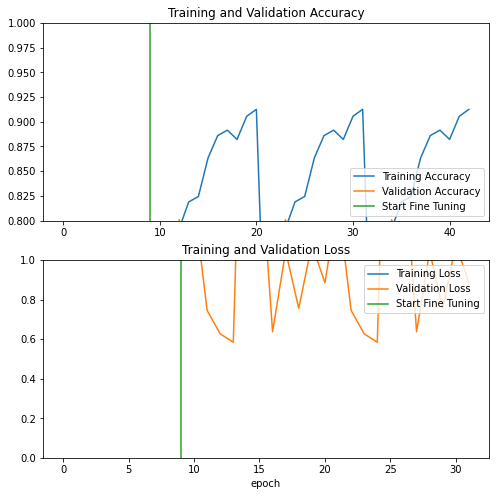

In [183]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [184]:
len(test_dataset)

2

In [185]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

KeyboardInterrupt: 

In [117]:
loss, accuracy = model.evaluate(validation_dataset)
print('Validation accuracy :', accuracy)

8/8 [==============================] - 7s 919ms/step - loss: 0.9424 - accuracy: 0.7461
Validation accuracy : 0.74609375


In [118]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

categ = [np.argmax(x) for x in predictions]

print('Predictions:\n', categ)
print('Labels:\n', label_batch)

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [3 1 4 3 3 1 4 3 3 3 1 3 4 1 3 4 2 2 1 4 3 2 1 2 1 3 3 4 0 1 1 1]


In [128]:
print('Predictions:\n', predictions.numpy())

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]


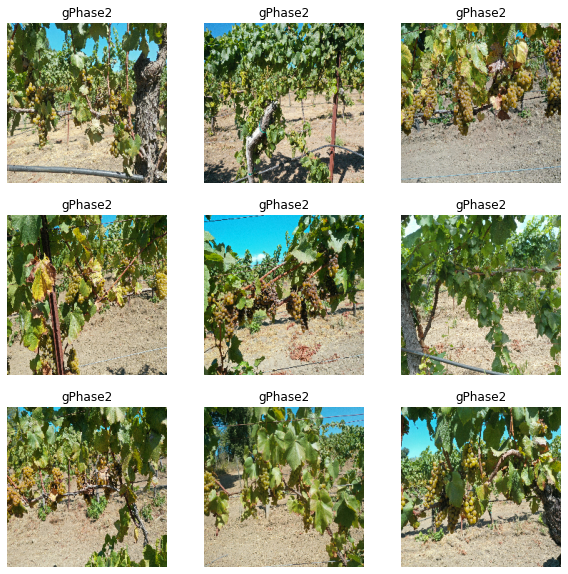

In [119]:
#plt.figure(figsize=(10, 10))
#for i in range(9):
#  ax = plt.subplot(3, 3, i + 1)
#  plt.imshow(image_batch[i].astype("uint8"))
#  plt.title(class_names[predictions[i]])
#  plt.axis("off")

In [74]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[categ[i]])
  plt.axis("off")